# Homework 4

## Question 2: Applied ML


## Loading the data
First we load the data and vectorize it.
The library functions contained in sklearn make this very straightforward.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# we use the builtin function for loading data
# sklearn already has a split in train/test, you can specify which data you want with the "subset" parameter
# since we will perform that split ourselves, we load all data
# we do not remove any metadata, this leads to much worse classification results

from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset="all")

In [3]:
# the newsgroups are an sklearn "bunch"
# it resembles a dictionary
newsgroups.keys()

dict_keys(['description', 'DESCR', 'filenames', 'target_names', 'target', 'data'])

In [4]:
# data contains the text for each article
newsgroups.data[0]

"From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"

In [5]:
# check how many articles we have
len(newsgroups.data)

18846

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# this will create a vector for every article
# the output is a matrix
# please note that we use a specific parametrization for the vectorizer:
# we exclude words that are too frequent, they are not specific enough to identify correlations with categories
# we also apply a smoothing operation
matrix = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english').fit_transform(newsgroups.data)

print(type(matrix))
print(matrix.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(18846, 173446)


## Splitting the data

We split the data into separate sets for training, testing and evaluating.
Following the usual naming convention in machine learning, we call these datasets

 - X_train, y_train
 - X_test, y_test
 - X_val, y_val
 
where X is the data and y contains the labels

In [7]:
# renaming
X = matrix
y = newsgroups.target

In [8]:
# now we do the split into train, test, val
# it's 0.8, 0.1, 0.1

num_samples = len(y)
num_train = int(0.8 * num_samples)
num_test = int(0.1 * num_samples)
num_val = int(0.1 * num_samples)

X_train = X[:num_train]
X_test = X[num_train : -num_val]
X_val = X[-num_val:]


y_train = y[:num_train]
y_test = y[num_train : -num_val]
y_val = y[-num_val:]

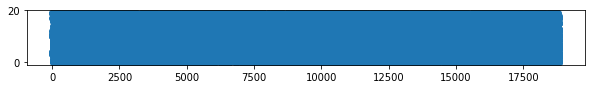

In [9]:
# we know whether the data is ordered
# it would be possible that we have all articles from category 1 first, then category 2, etc
# this would mean that our split is broken
# we take a look at the labels
# the scatterplot shows that there is no order, the labels don't increase linearly
plt.figure(figsize=(10,1))
plt.scatter(np.arange(len(y)), y)
plt.show()

## Searching for optimal parameters

### Fitting a RandomForest

Before we start the grid search, we fit a random forest, to see how the syntax looks.

We also want to check whether the classifier actually works, or if we have made some mistake. There are 20 categories. If the classifier is just guessing randomly, we would see an accuracy of about 1/20 = 5%. If the classifier does better than that, it is able to "learn" the data. That would mean we can continue to search for a good parametrization.

In [10]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
# use the classifier to predict labels for the test set
random_forest.score(X_test, y_test)

0.74549310710498407

The accuracy is already rather good. And this is for top-1 results. It would probably do much better if we would compute something like the top-2 or top-3 accuracy.

The number of estimators is 10 by default. I would like to get the max depth that was used in this tree. Then we can use these parameters as the center of our grid search.

In [12]:
# unfortunately, we are apparently not supposed to read the depth
# it is necessary to use properties with _ in their name
depths = [estimator.tree_.max_depth for estimator in random_forest.estimators_]


max_depth = max(depths)
avg_depth = sum(depths)/len(depths)

print("max depth is: ", max_depth)
print("avg depth is: ", avg_depth)

max depth is:  560
avg depth is:  451.9


### Gridsearch, 1st approach

We use the parameters given above to set up our gridsearch.

In [13]:
n_estimators = np.arange(10) + 5
max_depths = 7 * np.logspace(1, 2, num=5, dtype=np.int)

print("num estimators: ", n_estimators)
print("max depths: ", max_depths)

# we will use multithreading to process the grid on multiple cpus
# the load balancing of sklearn is not very complex
# it just splits the list and then collects the results
# but the parametrizations for more estimators / depths take much longer
# so we shuffle, as a simple load balancing
np.random.shuffle(n_estimators)
np.random.shuffle(max_depths)

num estimators:  [ 5  6  7  8  9 10 11 12 13 14]
max depths:  [ 70 119 217 392 700]


In [14]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from scipy.sparse import vstack

In [15]:
train_indices = [-1] * X_train.shape[0]
test_indices = [0] * X_test.shape[0]
indices = train_indices + test_indices

X_joint = vstack([X_train, X_test])
y_joint = np.concatenate([y_train, y_test])

pds = PredefinedSplit(indices)

### Loading saved states
Computing the grid searches takes a long time. We ended up doing 3 grid searches, and the third one takes many hours.
Therefore we use pickle to save the results to disk. We can load them instead of having to recompute them every time.

In [16]:
import pickle
rerun = False

In [17]:
if rerun:
    
    rfc = RandomForestClassifier()
    clf_grid1 = GridSearchCV(rfc, param_grid={'n_estimators':n_estimators, 'max_depth':max_depths}, cv=pds, n_jobs=-1)
    clf_grid1.fit(X_joint, y_joint)
    
    with open("data/clf_grid.pickle", "wb") as file:
        pickle.dump(clf_grid1, file)
else:
    with open("data/clf_grid.pickle", "rb") as file:
        clf_grid1 = pickle.load(file)

### Discussing results, for 1st GridSearch

The results on both the training and the test set are very good. We reach well above 90%.

But checking against the validation set shows that the results are not generalizable. We are not only overfitting the training data, the cross-validation of the parameters also resulted in training against the test set. We do note an improvement compared to the first evaluation, though.

The overfitting on the test set is so strong that we need to question whether our split is actually working. But it seems to be set up correctly.

In [18]:
# on the train and test set, our classifier performs very well
print("train score: ", clf_grid1.score(X_train, y_train))
print("test score: ", clf_grid1.score(X_test, y_test))

train score:  0.999469355267
test score:  0.999469777306


In [19]:
# but on the val set, we perform badly
print("test score: ", clf_grid1.score(X_val, y_val))

test score:  0.792993630573


In [20]:
# looking at the predefined splot
# it generates 1 set of train/test, that is good
print("the split generates {} splits into train and test set".format(pds.get_n_splits()))

# let's check the indices
# they also look good
train, test = next(pds.split())
print("the training indices go from {} to {}".format(train.min(), train.max()))
print("the testing indices go from {} to {}".format(test.min(), test.max()))

the split generates 1 splits into train and test set
the training indices go from 0 to 15075
the testing indices go from 15076 to 16961


### Gridsearch, 2nd approach
Our gridsearch is strongly overfitting.

Overfitting is usually due to too high model complexity. So we start a second gridsearch with reduced complexity.

In [21]:
n_estimators2 = n_estimators = np.arange(10) + 5
max_depths2 = 2 * np.logspace(1, 2, num=5, dtype=np.int)


print("num estimators: ", n_estimators2)
print("max depths: ", max_depths2)

np.random.shuffle(n_estimators2)
np.random.shuffle(max_depths2)

num estimators:  [ 5  6  7  8  9 10 11 12 13 14]
max depths:  [ 20  34  62 112 200]


In [22]:
if rerun:
    
    rfc = RandomForestClassifier()
    clf_grid2 = GridSearchCV(rfc, param_grid={'n_estimators':n_estimators2, 'max_depth':max_depths2}, cv=pds, n_jobs=-1)
    clf_grid2.fit(X_joint, y_joint)
    
    with open("data/clf_grid2.pickle", "wb") as file:
        pickle.dump(clf_grid2, file)
else:
    with open("data/clf_grid2.pickle", "rb") as file:
        clf_grid2 = pickle.load(file)

### Discussing results for the 2nd gridsearch

The performance is very similar to the first gridsearch

In [23]:
# on the train and test set, our classifier performs very well
print("train score: ", clf_grid2.score(X_train, y_train))
print("test score: ", clf_grid2.score(X_test, y_test))

train score:  0.992305651366
test score:  0.991516436903


In [24]:
# but on the val set, we perform badly
print("test score: ", clf_grid2.score(X_val, y_val))

test score:  0.781847133758


### Revisiting the baseline
Between the first and second gridsearch, we changed the maximum depth. Which had only very little effect on the performance.

We could also change the number of estimators, but this has a strong effect on the complexity and increases the time for training drastically.

Therefore, we do a simple check first: We train just one random forest, with a higher number of estimators and evaluate its performance.

In [25]:
rf2 = RandomForestClassifier(n_estimators=100)
rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
rf2.score(X_train, y_train)

0.99993366940833117

In [27]:
rf2.score(X_test, y_test)

0.85949098621420994

In [28]:
depths = [estimator.tree_.max_depth for estimator in rf2.estimators_]


max_depth = max(depths)
avg_depth = sum(depths)/len(depths)

print("max depth is: ", max_depth)
print("avg depth is: ", avg_depth)

max depth is:  545
avg depth is:  431.72


### Gridsearch for the 3rd time

Increasing the number of estimators improves both the training and the validation accuracy.
So we need to perform a gridsearch for higher amounts of estimators.
This will need a lot of time.
We set the gridsearch up to sample many configurations and let it run over night.

In [29]:
n_estimators3 = (40 * np.logspace(0, 1.5, num=20)).astype(np.int)
max_depths3 = 250 + (np.arange(10)*50)

print("num estimators: ", n_estimators3)
print("max depths: ", max_depths3)

np.random.shuffle(n_estimators3)
np.random.shuffle(max_depths3)

num estimators:  [  40   47   57   69   82   99  119  142  171  205  246  295  354  424  509
  611  733  879 1054 1264]
max depths:  [250 300 350 400 450 500 550 600 650 700]


In [30]:
if rerun:
    
    rfc = RandomForestClassifier()
    clf_grid3 = GridSearchCV(rfc, param_grid={'n_estimators':n_estimators3, 'max_depth':max_depths3}, cv=pds, n_jobs=-1)
    clf_grid3.fit(X_joint, y_joint)
    
    with open("data/clf_grid3.pickle", "wb") as file:
        pickle.dump(clf_grid3, file)
else:
    with open("data/clf_grid3.pickle", "rb") as file:
        clf_grid3 = pickle.load(file)

### Discussing results for the 3rd gridsearch

We are reaching almost 90% accuracy on the validation set now. I think this is an acceptable result.

In [31]:
# on the train and test set, our classifier performs very well
print("train score: ", clf_grid3.score(X_train, y_train))
print("test score: ", clf_grid3.score(X_test, y_test))

train score:  0.999933669408
test score:  1.0


In [32]:
# but on the val set, we perform badly
print("test score: ", clf_grid3.score(X_val, y_val))

test score:  0.892781316348


## Confusion matrix
We use the third grid search to plot a confusion matrix

In [33]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(clf_grid3.predict(X_val), y_val)

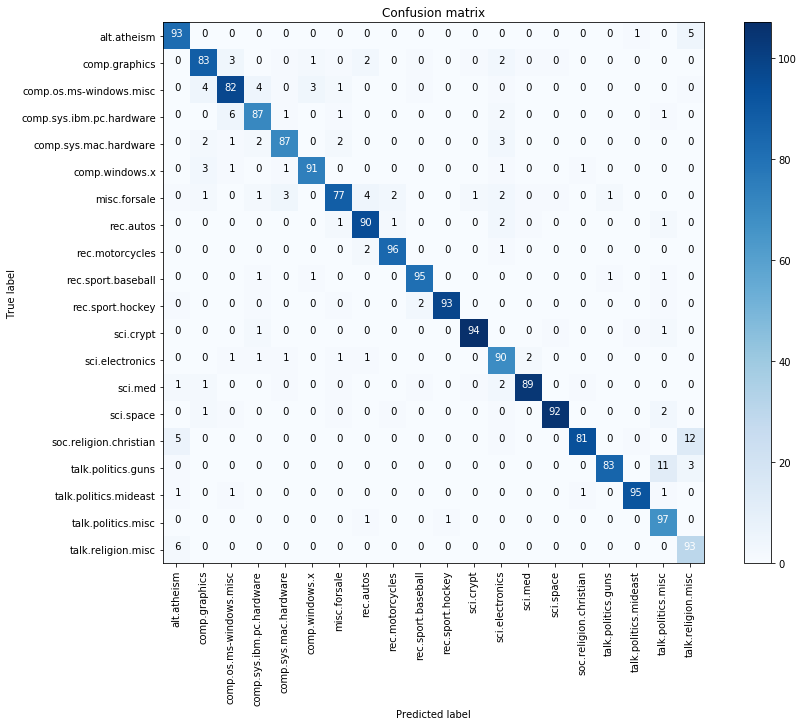

In [34]:
plt.figure(figsize=(13,10))

# plot the background colors
plt.title("Confusion matrix")
plt.imshow(cm, interpolation="None", cmap=plt.cm.Blues)
plt.colorbar()

# plot the category names
target_names = newsgroups.target_names
name_anchors = np.arange(len(target_names))
plt.xticks(name_anchors, target_names, rotation=90)
plt.yticks(name_anchors, target_names)

# normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot the confusion percentages, as text
# we need to change the text color based on the background color
# if the background is above a threshold, we use white as text color
thresh = cm.max() / 2.
for i in range(len(target_names)):
    for j in range(len(target_names)): 
        plt.text(j, i, "{:2d}".format(int(cm[i, j]*100)),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

## Discussing results

We have reached a validation accuracy of about 89%. This is accuracy, so it only takes the top result into consideration. In one of the comments above, we already mentioned that the model would probably do much better if it could also look at the top-2 or top-3 evaluations. The confusion matrix allows us to revisit this claim.
 - alt.atheism has a 93% accuracy, it is mostly confused with religion.misc. These topics are arguably very close.
 - soc.religion.christian is mostly confused with talk.religion.misc. Again, the topics are semantically close
 - talk.politics.guns is closest to talk.politics.misc
 
It is evident that the classifier is able to learn common structures in certain articles and topics. The classifier could be used to cluster topics by similarity.

We would also like to point out some decisions in setting up the classifier. In a first approach, we only used the content of the article and removed meta information. This leads to much worse results on both training and validation. We also decided to remove features that are too common in the vectorization. Words that occur frequently in every category are probably just common phrases in the language in general and not useful for article classification. A third choice was to apply a smoothing operation in the vectorization, this corresponds to the parameter _sublinear_tf_. Machine learning is very much an empirical approach to classification. We investigated the various combinations and this specific choice led to the best results. The framework of consecutive gridsearches, etc stayed the same during the review of different data preprocessing routines.